## Simulate AVIRIS as Sentinel-2 and compare with real Sentinel-2 image from the same day

In this notebook we will test the function `starcop.aviris.transform_to_sentinel_2` to load an AVIRIS image as if it was seen by Sentinel-2. Additionally we will compare with a real Sentinel-2 image from the same day.

**Note:** Simulation of all Sentinel-2 bands would require the full AVIRIS file with all 425 bands. As each scene takes around 20-30GB per file, we instead chose to demonstrate this simulation with a small crop of the data (512x512 image) using just the bands of interest (125 selected bands). This will allow us to demonstrate a simulation of the Sentinel-2 band 12. Please see Figure 2 in our paper for more details on the bands in multispectral and hyperspectral data. This allows us to run this demo in Colab.

## 1 Prepare libraries and data

In [ ]:
# Libraries and repository setup:

%cd /content/
!git clone https://github.com/spaceml-org/STARCOP.git

!pip install --quiet rasterio
!pip install --quiet --upgrade gdown
!pip install --quiet natsort pysolar

%cd /content/STARCOP
!pip install -q -r requirements.txt
# additional libraries and exact versions:
!pip install -q git+https://github.com/spaceml-org/georeader.git
!pip install -q torchmetrics==0.10.0

In [ ]:
# Data for this simulation (contains AVIRIS data for one methane plume event and a SAFE file for the corresponding area in Sentinel-2)
%cd /content/
# Instead of the full AVIRIS images we download a small area with only about 224MB
!gdown https://drive.google.com/uc?id=1wWVFOu8VD_Mefo_9Xw773NWosi_xVahu -O simulation_demo_data.zip
!unzip -q simulation_demo_data.zip
!rm simulation_demo_data.zip

!unzip -q S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE.zip
!rm S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE.zip

/content
Downloading...
From (uriginal): https://drive.google.com/uc?id=1wWVFOu8VD_Mefo_9Xw773NWosi_xVahu
From (redirected): https://drive.google.com/uc?id=1wWVFOu8VD_Mefo_9Xw773NWosi_xVahu&confirm=t&uuid=961dc76f-14a0-4a0c-82ce-deb0af0f30c8
To: /content/simulation_demo_data.zip
100% 224M/224M [00:02<00:00, 108MB/s]


In [ ]:
# PS: ^ You might need to restart the runtime in Colab after installing these libraries.

## 2 Run code

Now with the data and libraries prepared, we can run a simple demo which will simulate Sentinel-2 data from the STARCOP dataset.

In [ ]:
# These are the files we downloaded for this demo:
!ls /content/

# Description of the important folders:
# "ang20190928t185111_r6871_c424_w151_h151" - this is a folder of one of the events with a methane plume,
#                           we show here the postprocessed data (cropped to 512x512 and converted to TOA).
#                           It contains 125 bands kept in separate files, and few extra products.
#          + To know more:  Please check the main repository for description on how to download the
#                           rest of the dataset with this many bands (for most we require only a much smaller subset).
# "S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE" - this folder contains Sentinel-2 data
#                           in the SAFE format, as downloaded from a public gs bucket. For ease we kept only the
#                           bands we will use in this demo.
#          + To know more:  Optionally, check the end of this notebook for help with downloading new SAFE files for other locations.
#
# "STARCOP" - main codebase for our project

%cd /content/STARCOP

ang20190928t185111_r6871_c424_w151_h151				   sample_data
S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE  STARCOP
S2-SRF_joint.csv
/content/STARCOP


In [ ]:
import sys
sys.path.append("..")
import glob
import pylab as plt
import pandas as pd
import os
import numpy as np
import fsspec
import geopandas as gpd
from datetime import datetime, timezone
from natsort import os_sorted

from starcop.data import aviris
from georeader.readers import S2_SAFE_reader
from georeader.rasterio_reader import RasterioReader
from georeader import save_cog, read
from georeader.geotensor import GeoTensor

In the next cell we point to the downloaded AVIRIS image and prepare the reader to read over the plume location from the Permian basin dataset.

In [ ]:
%%time
folder = "/content/"
name = "ang20190928t185111"
date_acquisition_aviris = datetime.strptime(name, "ang%Y%m%dt%H%M%S").replace(tzinfo=timezone.utc)
allbands_folder = "/content/ang20190928t185111_r6871_c424_w151_h151"

reader_for_location = RasterioReader(os.path.join(allbands_folder, "TOA_AVIRIS_460nm.tif"))

tifs = [f for f in os_sorted(glob.glob(os.path.join(allbands_folder, "*"))) if "TOA_AVIRIS_" in f]
print("We have in total", len(tifs), "input bands available.")
reader_aviris = RasterioReader(tifs, stack=False, check=False)

bounds_loc = reader_for_location.bounds
center_coords = (bounds_loc[0] + bounds_loc[2]) / 2, (bounds_loc[1] + bounds_loc[3]) / 2
reader_aviris_loc = read.read_from_center_coords(reader_aviris, center_coords, crs_center_coords=reader_for_location.crs,
                                                 shape=(512, 512))
# reader_aviris_loc

We have in total 125 input bands available.
CPU times: user 80.4 ms, sys: 6.96 ms, total: 87.3 ms
Wall time: 104 ms


In [ ]:
# Here we can demonstrate simulation of bands B12 and B11 (because in terms of wavelenghts they overlap the demo data we downloaded here)
bands = ["B12", "B11"]
sensor = "S2B" # this can also be changed to "S2A"

bands_nanometers_aviris = [float(f.split("/")[-1].replace("TOA_AVIRIS_","").replace("nm.tif","")) for f in tifs]
aviris.load_srf_s2(path_override = os.path.join(folder,"S2-SRF_joint.csv"), drop_by_minimum = 460)
pass

These functions will convert the loaded AVIRIS data into a simulated Sentinel-2 product. Optionally we also show usage of a sigma gaussian filter for spatial degradation.

In [ ]:
%%time
aviris_as_s2 = aviris.transform_to_sentinel_2(reader_aviris_loc, bands_s2=bands,
                                              resolution_dst=20,sensor=sensor,
                                              bands_nanometers_aviris = bands_nanometers_aviris,
                                              verbose=True)

aviris_as_s2
print("Data is in:", aviris_as_s2.values.shape)

2023-09-03 20:59:38(0/2) Processing band B12
2023-09-03 20:59:38	 Loading 49 bands
2023-09-03 20:59:39	 bands loaded, computing tensor
2023-09-03 20:59:39(1/2) Processing band B11
2023-09-03 20:59:39	 Loading 22 bands
2023-09-03 20:59:40	 bands loaded, computing tensor
Data is in: (2, 190, 190)
CPU times: user 1.88 s, sys: 107 ms, total: 1.99 s
Wall time: 2.06 s


In [ ]:
%%time
aviris_as_s2_spectral = aviris.transform_to_sentinel_2(reader_aviris_loc, bands_s2=bands,
                                                       resolution_dst=None,sensor=sensor,
                                                       bands_nanometers_aviris = bands_nanometers_aviris,
                                                       verbose=True)

sigma_bands = np.array([max((aviris.BANDS_S2_RESOLUTION[b] / 7.4 - 1) / 2, 0)  for b in bands])
print("Sigma gaussian filter for spatial degradation: "+" ".join([f"{b}: {s:.4f}" for b,s in zip(bands,sigma_bands)]))
aviris_as_s2_spatiospectral = read.resize(aviris_as_s2_spectral, resolution_dst=20,
                                          anti_aliasing=True, anti_aliasing_sigma=sigma_bands)
aviris_as_s2_spatiospectral

2023-09-03 21:00:01(0/2) Processing band B12
2023-09-03 21:00:01	 Loading 49 bands
2023-09-03 21:00:02	 bands loaded, computing tensor
2023-09-03 21:00:02(1/2) Processing band B11
2023-09-03 21:00:02	 Loading 22 bands
2023-09-03 21:00:03	 bands loaded, computing tensor
Sigma gaussian filter for spatial degradation: B12: 0.8514 B11: 0.8514
CPU times: user 2.04 s, sys: 108 ms, total: 2.15 s
Wall time: 2.3 s


 
         Transform: | 16.18, 11.76, 590717.26|
| 11.76,-16.18, 3520211.18|
| 0.00, 0.00, 1.00|
         Shape: (2, 190, 190)
         Resolution: (20.00000000000059, 20.00000000021471)
         Bounds: (590717.2590559016, 3517136.913513607, 596025.1075932385, 3522444.7620509546)
         CRS: EPSG:32613
         fill_value_default: 0.0
        

In [ ]:
def rescale_geotensor(geo):
    """
    We use this function to rescale the already processed data (extracted allbands data)
    into the format that is used with raw AVIRIS data (moving the no-data value and
    also going from loaded TOA back to BOA).
    """

    data = geo.values.copy()

    # Get latitude and longitude of the center of image to compute the solar angle
    center_coords = geo.transform * (data.shape[-1] // 2, data.shape[-2] // 2)
    constant_factor = aviris.observation_date_correction_factor(center_coords, date_acquisition_aviris, crs_coords=geo.crs)

    fixed_b = np.where(data==0.0, np.nan, data)
    fixed_b = fixed_b / constant_factor
    fixed_b = np.nan_to_num(fixed_b, nan=-9999.0)

    r = GeoTensor(values=fixed_b, crs=geo.crs, transform=geo.transform,
                 fill_value_default=-9999.0)
    return r

aviris_as_s2_spatiospectral = rescale_geotensor(aviris_as_s2_spatiospectral)
aviris_as_s2 = rescale_geotensor(aviris_as_s2)

### Convert `aviris_as_s2` to TOA reflectance

In [ ]:
## Load corresponding area from real world Sentinel-2 data
s2path = "/content/S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE"

s2_reader = S2_SAFE_reader.s2loader(s2path, out_res=20, bands=bands)
s2_at_aviris_loc = read.read_reproject_like(s2_reader, aviris_as_s2)

s2_at_aviris_loc

 
         Transform: | 16.18, 11.76, 590717.26|
| 11.76,-16.18, 3520211.18|
| 0.00, 0.00, 1.00|
         Shape: (2, 190, 190)
         Resolution: (20.00000000000059, 20.00000000021471)
         Bounds: (590717.2590559016, 3517136.913513607, 596025.1075932385, 3522444.7620509546)
         CRS: EPSG:32613
         fill_value_default: 0
        

In [ ]:
bands = S2_SAFE_reader.normalize_band_names(bands)
solar_irradiance = np.array([aviris.SOLAR_IRRADIANCE[sensor][b] for b in bands])

# spectral
aviris_as_s2_TOA = aviris.radiance_to_reflectance(aviris_as_s2, solar_irradiance,
                                                  date_of_acquisition=date_acquisition_aviris)


# spectral and spatial
aviris_as_s2_spatiospectral_TOA = aviris.radiance_to_reflectance(aviris_as_s2_spatiospectral,
                                                           solar_irradiance,
                                                           date_of_acquisition=date_acquisition_aviris)

aviris_as_s2_TOA

debug constant_factor 3.8020849281829765
debug constant_factor 3.8020849281829765


 
         Transform: | 16.18, 11.76, 590717.26|
| 11.76,-16.18, 3520211.18|
| 0.00, 0.00, 1.00|
         Shape: (2, 190, 190)
         Resolution: (20.00000000000059, 20.00000000021471)
         Bounds: (590717.2590559016, 3517136.913513607, 596025.1075932385, 3522444.7620509546)
         CRS: EPSG:32613
         fill_value_default: -9999.0
        

## Show and compare the real and simulated data

Band B12


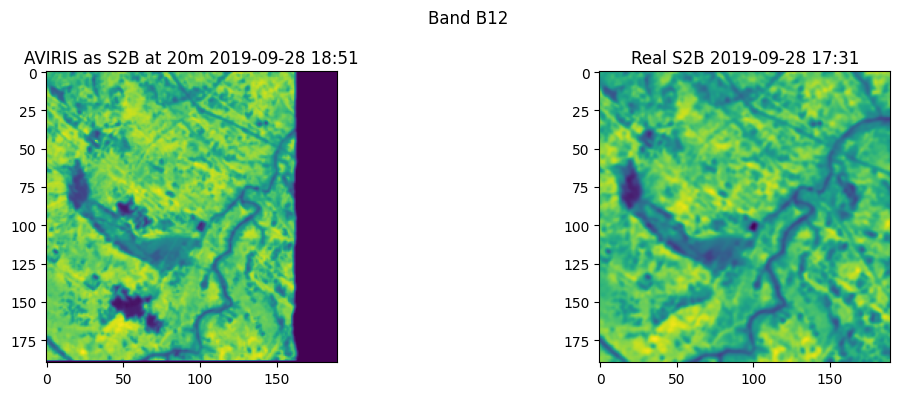

Band B11


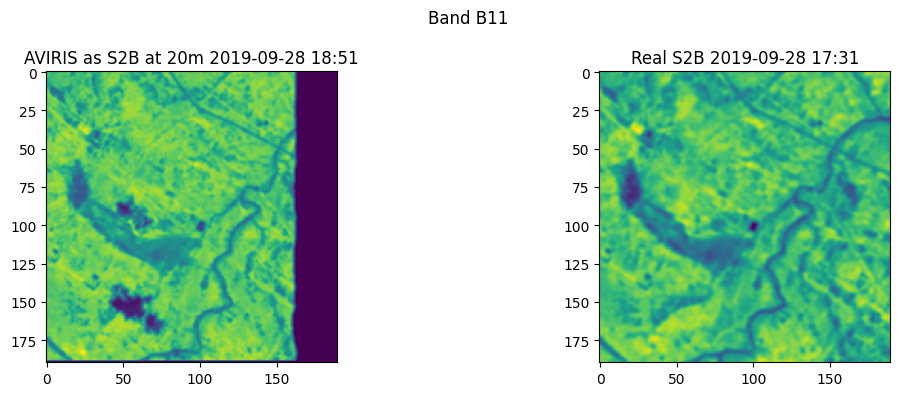

In [ ]:
# Plotting:
for idx in range(len(bands)):
    fig, ax = plt.subplots(1,2,figsize=(12,4),tight_layout=True)

    title_str = "Band " + str(bands[idx])
    print(title_str)

    ax[0].imshow(np.clip(aviris_as_s2_TOA.values[idx],0,1))
    ax[0].set_title(f"AVIRIS as {sensor} at 20m {date_acquisition_aviris.strftime('%Y-%m-%d %H:%M')}")

    # optionally also show:
    # ax[1].imshow(np.clip(aviris_as_s2_spatiospectral_TOA.values[idx],0,1))
    # ax[1].set_title(f"AVIRIS as {sensor} at 20m (with Sigma gaussian filter) {date_acquisition_aviris.strftime('%Y-%m-%d %H:%M')}")

    ax[-1].imshow(np.clip(s2_at_aviris_loc.values[idx]/10_000,0,1))
    ax[-1].set_title(f"Real {s2_reader.mission} {s2_reader.datetime.strftime('%Y-%m-%d %H:%M')}")

    plt.suptitle(title_str)
    plt.show()
    #plt.savefig("figures/aviris_as_s2.pdf")


### Histogram by band

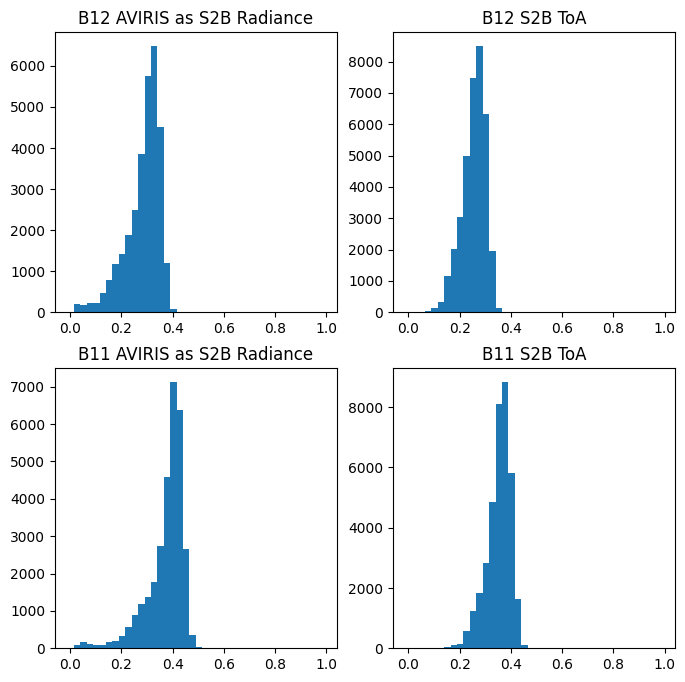

In [ ]:
fig, ax = plt.subplots(len(bands), 2, figsize=(8,4*len(bands)))
for i,b in enumerate(bands):
    ax[i,0].hist(aviris_as_s2_TOA.values[i].ravel(), bins=np.arange(-0.01,1,.025), label="AVIRIS")
    ax[i,1].hist(s2_at_aviris_loc.values[i].ravel()/10_000, bins=np.arange(-0.01,1,.025), label="S2")
    ax[i,0].set_title(f"{b} AVIRIS as S2B Radiance")
    ax[i,1].set_title(f"{b} S2B ToA")


## Save the converted data

In [ ]:
save_cog.save_cog(aviris_as_s2, "aviris_as_s2.tif", descriptions=bands)
save_cog.save_cog(aviris_as_s2_TOA, "aviris_as_s2_TOA.tif", descriptions=bands)
save_cog.save_cog(s2_at_aviris_loc, "sentinel2_reference.tif", descriptions=bands)

In [ ]:
!ls -luah *.tif

-rw-r--r-- 1 root root 288K Sep  3 17:49 aviris_as_s2.tif
-rw-r--r-- 1 root root 607K Sep  3 17:49 aviris_as_s2_TOA.tif
-rw-r--r-- 1 root root 161K Sep  3 17:49 sentinel2_reference.tif


### (Bonus) Search for SAFE files for any location

In [ ]:
!pip install sat-search

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 4.4 MB/s eta 0:00:00
  Created wheel for sat-search: filename=sat_search-0.3.0-py3-none-any.whl size=9235 sha256=a278b9c521e6b49b75b1fbf177979e47a794bff3045da19ee995df48f4edcc05
  Stored in directory: /root/.cache/pip/wheels/0a/45/1c/4eabbdbd7276174ae8d178e8bc6607b6c15497934129c33242
  Created wheel for sat-stac: filename=sat_stac-0.4.1-py3-none-any.whl size=15177 sha256=4569cefbcebdae8fd3d7b68a00a4559a15fd290466ddf69e278def77cb80c98c
  Stored in directory: /root/.cache/pip/wheels/15/af/d2/fa8c95eea27defc7d5948892895b0442ad47f95d9c15b4ece7
Successfully built sat-search sat-stac
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      Successfully uninstalled python-dateutil-2.8.2
ERROR: pip's dependency resolver does not currently take into account all the package

In [ ]:
import satsearch
from shapely.geometry import shape
from georeader.readers import S2_SAFE_reader

bbox = tuple(aviris_as_s2.bounds)
dates = date_acquisition_aviris.strftime("%Y-%m-%d")+"/"+date_acquisition_aviris.strftime("%Y-%m-%d")

URL='https://earth-search.aws.element84.com/v0'
results = satsearch.Search.search(url=URL, collections=['sentinel-s2-l2a-cogs'],
                                  datetime=dates,
                                  bbox=bbox,
                                  sort=['<datetime'])
print('%s items' % results.found())
items = results.items()


features = items.geojson()["features"]
dates = items.dates()
print("Dates:", dates)

feature = features[0]
s2obj = S2_SAFE_reader.s2_load_from_feature_element84(features[0],bands=["B02"])

# in theory could down from this path ...
print("The path to the public s2 bucket:")
print(S2_SAFE_reader.s2_public_bucket_path(s2obj.name))

# use this with !gsutils cp -r <PATH> .
# but not with anonymous access (you might need to log in)

280 items
Dates: [datetime.date(2019, 9, 28)]
The path to the public s2 bucket:
gs://gcp-public-data-sentinel-2/tiles/09/J/TM/S2A_MSIL2A_20190928T185111_N0213_R127_T09JTM_20190928T220537.SAFE
